# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Packages

In [2]:
## install some extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

# Import Libraries

In [3]:
!git clone https://github.com/openai/CLIP.git /content/drive/MyDrive/Image_From_Text_GAN/CLIP
!git clone https://github.com/CompVis/taming-transformers /content/drive/MyDrive/Image_From_Text_GAN/taming-transformers

fatal: destination path '/content/drive/MyDrive/Image_From_Text_GAN/CLIP' already exists and is not an empty directory.
fatal: destination path '/content/drive/MyDrive/Image_From_Text_GAN/taming-transformers' already exists and is not an empty directory.


In [4]:
import numpy as np
import torch
import os
import imageio
import pdb
import math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf

from drive.MyDrive.Image_From_Text_GAN.CLIP import clip

from IPython.display import HTML
from base64 import b64encode

# Helper Functions

In [5]:
def show_from_tensor(tensor):#show image from input tensor
    img = tensor.clone()
    img = img.mul(255).byte()
    img = img.cpu().numpy().transpose((1,2,0))
    
    plt.figure(figsize=(10,7))
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
def norm_data(data):
    return (data.clip(-1,1)+1)/2

# Parameters & Hyper-Parameters

In [6]:
learning_rate = 0.5
batch_size = 1
wd = 0.1 #weight decay
noise_factor = .1 #0.22
total_iterations = 100# 400
img_shape = [225,400,3] #[450, 450, 3] #H W Channel
size1, size2, channels = img_shape#size1 - height, size2- width

# Instantiating CLIP Model

In [7]:
clip_model, _ = clip.load('ViT-B/32', jit=False)
clip_model.eval() #not needed to train again
print(clip.available_models())
print('Clip Model Visual Input Resolution :', clip_model.visual.input_resolution)

device= torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']
Clip Model Visual Input Resolution : 224


We'll use 'ViT-B/32' in ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']<br>
Input images are to be encoded with 224 pixels

# Instantiating Taming Transformer

In [8]:
%cd drive/MyDrive/Image_From_Text_GAN/taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml' 

/content/drive/MyDrive/Image_From_Text_GAN/taming-transformers


In [9]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
    config_data = OmegaConf.load(config_path)
    if(display):
        print(yaml.dump(OmegaConf.to_container(config_data)))
    return config_data

def load_vqgan(config, chk_path=None):
    model = VQModel(**config.model.params)
    if(chk_path is not None):
        state_dict = torch.load(chk_path, map_location='cpu')['state_dict']
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
    return model.eval() #not going to train

def generator(x):
    x = taming_model.post_quant_conv(x)
    x = taming_model.decoder(x)
    return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


# Declare parameters

In [10]:
class Parameters(torch.nn.Module):
    def __init__(self):
        super(Parameters, self).__init__()
        #batch_size=1, 256 channels(needed by VQGAN) size-size to generate225x400
        self.data = 0.5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1(batch_size)x256(channels)x14(225//16)x25(400//16)
        # divide by 16 for compatibility for transformer
        self.data = torch.nn.Parameter(torch.sin(self.data))
    def forward(self):
        return self.data

In [11]:
def init_params():#re-initialize parameters again
    params=Parameters().cuda()
    optimizer = torch.optim.AdamW([{'params':[params.data], 'lr':learning_rate}], weight_decay=wd)
    return params, optimizer

In [12]:
params, optimizer = init_params()

# Encoding Text Prompts (Using CLIP)

In [13]:
def encodeText(text):#encode text using CLIP
    t=clip.tokenize(text).cuda()
    t=clip_model.encode_text(t).detach().clone()
    return t

def create_encodings(include, exclude, extras):#what to include, exclude; extras-some extras to apply for includes
    include_enc =[]
    for text in include:
        include_enc.append(encodeText(text))
    exclude_enc = encodeText(exclude) if exclude != '' else 0
    extras_enc = encodeText(extras) if extras != '' else 0
    
    return include_enc, exclude_enc, extras_enc

#augmentation of images which is needed by CLIP (CLIP needs crop images. the more the variation the better the CLIP understanding)
aug_Transform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2))
).cuda()

torch.Size([1, 256, 14, 25])
image dimensions : torch.Size([1, 3, 224, 400])


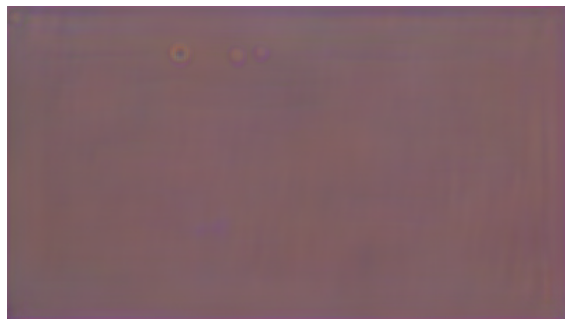

In [14]:
# test to generate image with random parameters
with torch.no_grad():
    print(params().shape)
    img = norm_data(generator(params()).cpu()) # 1 x 3(channels) x 224(224 rounded to 225) x 400
    print('image dimensions :',img.shape)
    show_from_tensor(img[0])

# Create Crops To Pass to Encode the image
Clip Needs variations of images not one single image

In [15]:
def create_crops(img, num_crops=32):
    p = size1//2
    #pad before transformations
    img = torch.nn.functional.pad(img,(p,p,p,p), mode='constant', value=0)#zero padding on all sides of image 1x3x448x624(since 112*2 is added on all sides to 224x400)
    img = aug_Transform(img)
    crop_set = [] #cropping
    for ch in range(num_crops):
        gap1 = int(torch.normal(1.0, .5, ()).clip(.2, 1.5)*size1)
        #gap1 = int(torch.normal(1.2, .3, ()).clip(.43, 1.9)*size1)
        
        offset_x = torch.randint(0, int(size1*2-gap1), ())#offset in x axis
        offset_y = torch.randint(0, int(size1*2-gap1), ())#offset in y axis
        
        crop = img[:,:,offset_x:offset_x+gap1, offset_y:offset_y+gap1]
        crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)#interpolate - resize
        crop_set.append(crop)
    
    img_crops = torch.cat(crop_set, 0) # 30(30 crops) x 3(channels) x 224(height) x 224(width) cat-concat
    randnormal = torch.randn_like(img_crops, requires_grad=False)
    num_rands=0
    randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda()
    
    for ns in range(num_rands):
        randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()
        
    img_crops = img_crops + noise_factor*randstotal*randnormal # add some noise to crops
    
    return img_crops    

# Display Generated Images (Crops also)

In [16]:
def display(params, show_crop):
    with torch.no_grad():
        generated = generator(params())
        if(show_crop):#optional display augmented cropped image
            print('Augmented Crop Example')
            aug_gen = generated.float() #1 x 3 x 224(not 225) x 400
            aug_gen = create_crops(aug_gen, num_crops=1)#ask for one crop
            aug_gen_norm = norm_data(aug_gen[0]) #normalize
            show_from_tensor(aug_gen_norm)
        print('Generated Image')
        latest_gen = norm_data(generated.cpu()) # 1 x 3 x 224 x 400
        show_from_tensor(latest_gen[0])
    return latest_gen[0]

# Optimization

In [17]:
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
#already prepared parameters while training CLIP (they are just mean and variance)

In [18]:
def optimize_result(params, prompt):
    alpha = 1 #importance of include encoding
    beta = .5 #importance of exclude encoding
    
    #image encoding
    out = generator(params())
    out = norm_data(out)
    out = create_crops(out)
    out = normalize(out) #extra normalization for CLIP compatibility 30 x 3 x 224 x 224
    img_encode = clip_model.encode_image(out)    #encode image  30 x 512 (for each crop encoded value)
    
    #text encoding w1-include encoding weight; w2-extra encoding weight
    final_enc = w1*prompt + w1*extras_enc #prompt & extras_enc : 1 x 512
    final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
    final_text_exclude_enc = exclude_enc
    
    #calc loss
    main_loss = torch.cosine_similarity(final_text_include_enc, img_encode, -1) # 30
    penalize_loss = torch.cosine_similarity(final_text_exclude_enc, img_encode, -1) #30
    
    final_loss = -alpha*main_loss + beta*penalize_loss
    return final_loss

def loss_fn(params, optimizer, prompt): #returns loss
    loss = optimize_result(params, prompt).mean() #mean loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

# Training

In [19]:
def training(params, optimizer, show_crop=False):
    res_img = [] #images
    res_z = [] #parameters
    
    for prompt in include_enc:
        iteration = 0
        params, optimizer = init_params() # 1 x 256 x 14(225/16) x 25(400/16)
        
        for i in range(total_iterations):
            loss = loss_fn(params, optimizer, prompt)
            if((iteration>80) and iteration%(total_iterations-1) == 0):
                new_img = display(params, show_crop)
                res_img.append(new_img)
                res_z.append(params()) # 1 x 256 x 14 x 25
                print('Loss :', loss.item(), '\nIteration :', iteration)
            
            iteration+=1
        torch.cuda.empty_cache()
    return res_img, res_z

# Test Case 1

In [ ]:
torch.cuda.empty_cache()
#include = ['sketch of a lady', 'sketch of a man on horse']
#exclude = 'watermark, cropped, confusing, incoherent, cut, blurry'
#extras = 'watercolor paper texture'

include = ['A painting of a pineapple in a bowl']
exclude='watermark'
extras=''
noise_factor= .22
total_iter=400

w1=1
w2=1
include_enc, exclude_enc, extras_enc = create_encodings(include, exclude, extras)
res_img, res_z = training(params, optimizer, show_crop=True)

# Test Case 2

In [ ]:
torch.cuda.empty_cache()
#include = ['A forest with purple trees', 'two boxers fighting in a boxing ring', 'a boy at the top of a mountain, looking at the stars', 'a boy at the top of a mountain, looking at the stars', 'one hundred people with blue jackets', 'one hundred people with blue jackets']
include = ['a elephant at the top of a mountain, looking at the stars', 'one hundred people with green jackets']
exclude = 'watermark, cropped, confusing, incoherent, cut, blurry'
extras = ''
w1=1
w2=1
#noise_factor= .22
#total_iter=110
#show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = create_encodings(include, exclude, extras)
res_img, res_z = training(params, optimizer, show_crop=True)

# Interpolation

In [25]:
def interpolate(res_z_list, duration_list):
  gen_img_list = []
  fps = 25

  for idx, (z,duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1=z
    z2=res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25

    for step in range(num_steps):
      alpha = math.sin(1.5*step/num_steps)**6
      z_new = alpha * z2 + (1-alpha)*z1

      new_gen = norm_data(generator(z_new).cpu())[0] # 3 x 224 400
      new_img = T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)
  return gen_img_list

durations=[5,5,5,5,5,5]
interpulation_res_img_list = interpolate(res_z, durations)

# Create Video

In [26]:
out_video_path = '/content/drive/MyDrive/Image_From_Text_GAN/Video_1.mp4'
writer = imageio.get_writer(out_video_path, fps=25)
for pil_img in interpulation_res_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)
writer.close()

# Display Video

In [27]:
mp4 = open('../Video_1.mp4', 'rb').read()
data = 'data:video/mp4;base64'+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>"""%data)